In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers

**HUPA Dataset**


In [63]:
Hupa_df = pd.read_csv("https://raw.githubusercontent.com/natalio123/FitGuard/main/data/HUPA_DATASET.csv")
Hupa_df.head()

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
0,2018-06-13 18:40:00,332.0,6.3595,82.322835,34,0.091667,0.0,0.0
1,2018-06-13 18:45:00,326.0,7.7280,83.740157,0,0.091667,0.0,0.0
2,2018-06-13 18:50:00,330.0,4.7495,80.525180,0,0.091667,0.0,0.0
3,2018-06-13 18:55:00,324.0,6.3595,89.129032,20,0.091667,0.0,0.0
4,2018-06-13 19:00:00,306.0,5.1520,92.495652,0,0.075000,0.0,0.0


Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input'],
      dtype='object')
Number of duplicate rows after removal: 0
time                      0
glucose                   0
calories                  0
heart_rate                0
steps                     0
basal_rate                0
bolus_volume_delivered    0
carb_input                0
dtype: int64


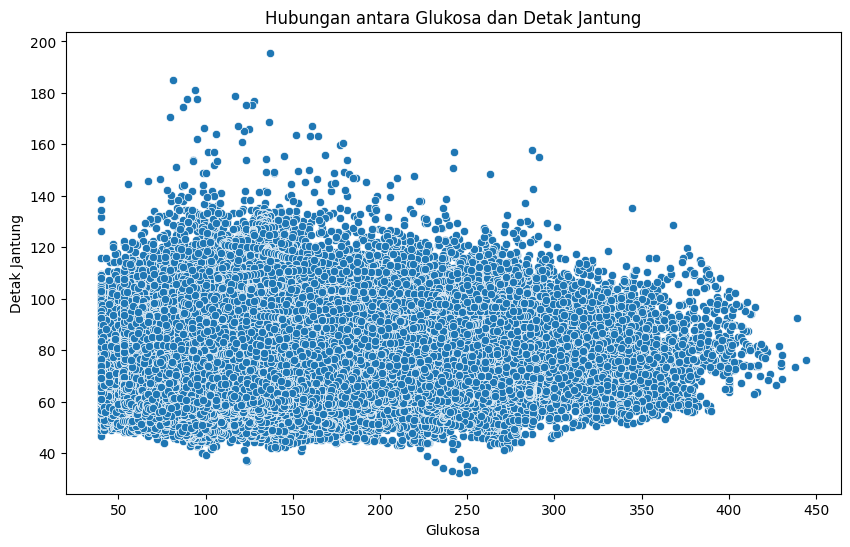

In [64]:
# Remove duplicate rows
Hupa_df.drop_duplicates(inplace=True)
print(Hupa_df.columns)
# Verify that duplicates have been removed
print(f"Number of duplicate rows after removal: {Hupa_df.duplicated().sum()}")

print(Hupa_df.isnull().sum())

# Visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Contoh visualisasi hubungan antara glukosa dan detak jantung
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Hupa_df, x='glucose', y='heart_rate')
plt.title('Hubungan antara Glukosa dan Detak Jantung')
plt.xlabel('Glukosa')
plt.ylabel('Detak Jantung')
plt.show()

In [65]:
# Ubah kolom 'time' menjadi format datetime
Hupa_df['time'] = pd.to_datetime(Hupa_df['time'])

# 2. Ekstrak Fitur dari Kolom 'time' (pilih hanya beberapa fitur)
Hupa_df['hour'] = Hupa_df['time'].dt.hour
Hupa_df['day_of_week'] = Hupa_df['time'].dt.dayofweek

# 3. Pra-pemrosesan Data
X = Hupa_df[['hour', 'day_of_week', 'calories', 'heart_rate', 'steps', 'basal_rate', 'bolus_volume_delivered', 'carb_input']]
y = Hupa_df['glucose']

In [66]:
from sklearn.preprocessing import StandardScaler
# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Bagi Dataset Menjadi Data Latih dan Data Validasi
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import load_model
# 4. Muat Model Pre-trained
# model_fg = tf.keras.models.load_model('/Users/Yersolid/Documents/Studi/diabetes_prediction_model.h5')
# model_fitguard = tf.keras.models.load_model('/Users/Yersolid/Documents/Studi/best_model.keras')

# input_shape = (X_train.shape[1],)
# model_fg.build((None, input_shape[0]))  

model = load_model('model/diabetes_prediction_model.h5')

# input_shape = (X_train.shape[1],)

In [68]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691 (10.52 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [69]:
# 5. Sesuaikan Model
def customize_model(base_model, input_shape):
    """
    Customize a base model by freezing its layers and adding additional layers.

    Args:
        base_model: A pre-trained model to be customized.
        input_shape: A tuple representing the shape of the input data.

    Returns:
        A compiled Keras model with the base model and additional layers.
    """
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new sequential model
    model = models.Sequential([
        layers.Input(shape=input_shape),
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model



custom_base_model = customize_model(base_model, input_shape)
# custom_model_fitguard = customize_model(model_fitguard, input_shape)

In [70]:
print("Model Summary:")
custom_base_model.summary()

Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 1)              │         2,689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,074 (12.01 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 2,689 (10.50 KB)

In [71]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (112204, 8)
y_train shape: (112204,)
X_val shape: (28052, 8)
y_val shape: (28052,)


In [72]:
# 6. Latih Model
# custom_model_fg.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
print("Starting training...")
history = custom_base_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
print("Training completed.")


Starting training...
Epoch 1/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 15600.6064 - mae: 102.7738 - val_loss: 4392.8701 - val_mae: 52.8553
Epoch 2/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4274.8276 - mae: 52.2161 - val_loss: 4230.7134 - val_mae: 51.9603
Epoch 3/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4195.1553 - mae: 51.7436 - val_loss: 4229.1582 - val_mae: 51.9101
Epoch 4/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4196.3530 - mae: 51.8404 - val_loss: 4228.4175 - val_mae: 51.9478
Epoch 5/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4224.1240 - mae: 51.9873 - val_loss: 4227.3701 - val_mae: 52.0341
Epoch 6/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4200.0898 - mae: 51.7844 - val_loss: 4227.4990 - val_mae: 52.0232
Epoch 7/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4191.2373 - mae: 51.8170 - val_loss: 4227.2363 - val_mae: 52.0708
Epoch 8/10
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4178.3662 - mae: 5

In [73]:
loss, mae = custom_base_model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation MAE: {mae}")

877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4222.5386 - mae: 51.7859
Validation Loss: 4228.763671875
Validation MAE: 51.94939422607422


877/877 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step


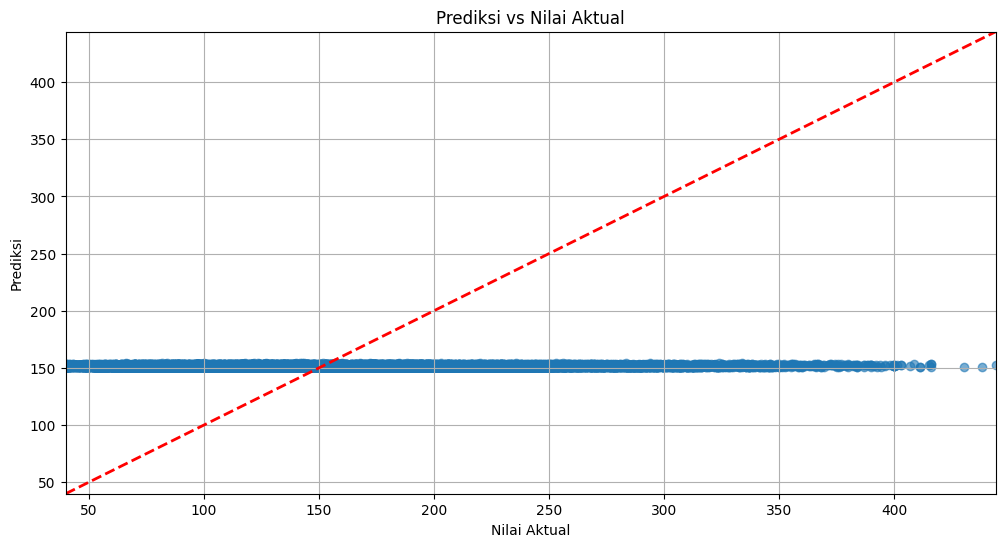

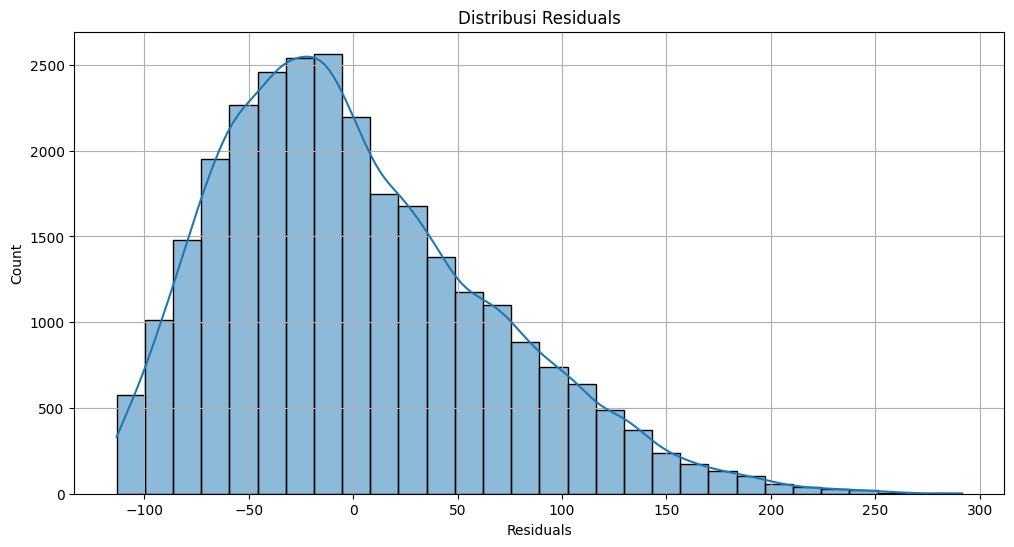

In [74]:
predictions = custom_base_model.predict(X_val)

# Visualisasi: Prediksi vs Nilai Aktual
plt.figure(figsize=(12, 6))
plt.scatter(y_val, predictions, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()], 'r--', lw=2)  # Garis referensi
plt.xlabel('Nilai Aktual')
plt.ylabel('Prediksi')
plt.title('Prediksi vs Nilai Aktual')
plt.xlim(y_val.min(), y_val.max())
plt.ylim(y_val.min(), y_val.max())
plt.grid()
plt.show()

# Visualisasi: Histogram dari Residuals
residuals = y_val - predictions.flatten()
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Distribusi Residuals')
plt.grid()
plt.show()